## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn2.ipynb의 조금 코드를 수정한 버전

In [1]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [3]:
env = gymnasium.make('CartPole-v1')
env._max_episode_steps = 10000
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q).requires_grad_(False)

In [4]:
lr = 0.00001
discount = 0.99
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(q.parameters(), lr=lr, amsgrad=True)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600  
batch_size = 128
sync_interval = 10
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [5]:
steps = []
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-i / eps_decay)
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        replay_buffer.append(state, action, reward, next_state, terminated)
        
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(0)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_values[batch.terminated] = target_q(batch.next_state[batch.terminated]).max(1).values
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(q.parameters(), 100)
            optimizer.step()
            
        state = next_state
        if terminated or truncated:
            break
    
    steps.append(step)

    if (i + 1) % sync_interval == 0:
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict() 
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)

    if (i + 1) % 100 == 0:
        print(np.mean(steps[-100:]))

 17%|█▋        | 102/600 [00:05<00:26, 18.90it/s]

20.95


 34%|███▍      | 204/600 [00:11<00:28, 14.02it/s]

20.28


 50%|█████     | 300/600 [00:19<00:25, 11.91it/s]

23.96


 67%|██████▋   | 402/600 [00:29<00:14, 13.91it/s]

28.86


 84%|████████▎ | 501/600 [00:34<00:04, 21.12it/s]

15.39


100%|██████████| 600/600 [00:39<00:00, 15.14it/s]

13.11


In [6]:
len(replay_buffer)

10000

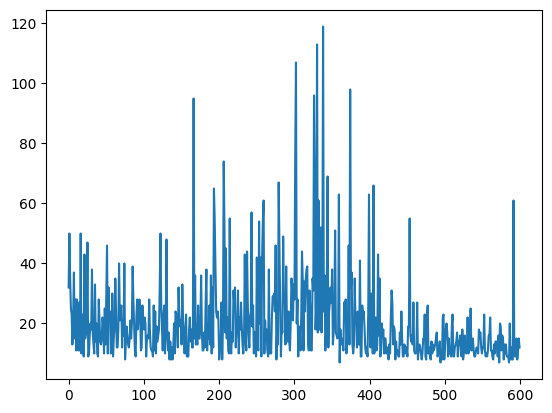

In [7]:
import matplotlib.pyplot as plt
plt.plot(steps)

In [8]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[9.0, 9.0, 10.0, 9.0, 10.0, 8.0, 9.0, 10.0, 10.0, 10.0]

In [9]:
env.close()

In [10]:
env = gymnasium.make('CartPole-v1')